# Imports

In [1]:
import os, sys
os.environ["PATH"] += os.pathsep +"/Library/TeX/texbin/latex"

dtype = "float32"
MAIN = "/Users/abidaurrazaga/Desktop/PhD/SparseWeightsRBM"
nb_path = '/Users/abidaurrazaga/Desktop/PhD/SparseWeightsRBM/Modules'
sys.path.append(nb_path)

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn
import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Lucida"]})

In [6]:
#remove_all_but(but=["epochs_5000"])

Removed 0 files


! sudo apt-get install texlive-latex-recommended 
! sudo apt install texlive-latex-extra
! sudo apt install dvipng
! sudo apt install cm-super

# Weight visualization

In [ ]:
DATA_NAME = "MNIST"
hidden = "81"
classification = False
SEED = 9
train_size = str(int(60000/(2**0)))
seed_str = "seed_"+str(SEED)
DIR = os.path.join(MAIN,"Trained RBM/%s"%DATA_NAME)

for model_name in os.listdir(DIR):
    if train_size in model_name:
        if hidden in model_name:
            if seed_str in model_name:
                if classification:
                    if "classRBM" in model_name:
                        if "window" in model_name:
                            sbm_name = model_name
                        if not ("window" in model_name):
                            rbm_name = model_name
                else:
                    if not "classRBM" in model_name:
                        if "window" in model_name:
                            sbm_name = model_name
                        if not ("window" in model_name):
                            rbm_name = model_name

In [ ]:
print(rbm_name)
print(sbm_name)

In [ ]:
from Save_Load import load_rbm
rbm = load_rbm(rbm_name,MAIN = MAIN,output_dir=DIR)
sbm = load_rbm(sbm_name,MAIN = MAIN,output_dir=DIR)

In [ ]:
print("RBM run for %s epochs"%len(rbm.history[list(rbm.history)[0]]))
print("SBM run for %s epochs"%len(sbm.history[list(sbm.history)[0]]))

In [ ]:
#! pip install -U scikit-learn
sklearn.__version__

In [ ]:
from sklearn.cluster import SpectralBiclustering as Bicluster

model = Bicluster(n_clusters=25,method="scale",random_state=0)
model.fit(rbm.W)
rbmW = rbm.W.numpy()[np.argsort(model.row_labels_)]
rbmW = rbmW[:, np.argsort(model.column_labels_)]
fig,ax = plt.subplots(1,2,figsize=(15,6))
fig.suptitle("Model weights, n_hidden = "+hidden,fontsize=20)
pos1 = ax[0].imshow(rbmW,cmap = "plasma",aspect = "auto")
fig.colorbar(pos1,ax=ax[0])
ax[0].set_title("RBM",fontsize=20)
pos2 = ax[1].imshow(sbm.W,cmap = "plasma",aspect = "auto")
fig.colorbar(pos2,ax=ax[1])
ax[1].set_title("SBM",fontsize=20)
plt.savefig(os.path.join(MAIN,"Images","Model_Weights_n_hidden%s.pdf"%hidden))
plt.show()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,6))
fig.suptitle("Visible units weight sum + visible bias, n_hidden = "+hidden,fontsize=20)
pos1 = ax[0].imshow(np.sum(rbm.W,axis=1).reshape((28,28))/rbm.W.shape[1]+rbm.visible_bias.numpy().reshape((28,28)),cmap = "plasma",aspect = "auto")
fig.colorbar(pos1,ax=ax[0])
ax[0].set_title("RBM",fontsize=20)
pos2 = ax[1].imshow(np.sum(sbm.W,axis=1).reshape((28,28))/np.sum(sbm.mask,axis=1).reshape((28,28))+sbm.visible_bias.numpy().reshape((28,28)),cmap = "plasma",aspect = "auto")
fig.colorbar(pos2,ax=ax[1])
ax[1].set_title("SBM",fontsize=20)
plt.savefig(os.path.join(MAIN,"Images","Weights_sum_and_bias_n_hidden%s.pdf"%hidden))
plt.show()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,6))
fig.suptitle("Visible units weight sum, n_hidden = "+hidden,fontsize=20)
pos1 = ax[0].imshow(np.sum(rbm.W,axis=1).reshape((28,28)),cmap = "plasma",aspect = "auto")
fig.colorbar(pos1,ax=ax[0])
ax[0].set_title("RBM",fontsize=20)
pos2 = ax[1].imshow(np.sum(sbm.W,axis=1).reshape((28,28)),cmap = "plasma",aspect = "auto")
fig.colorbar(pos2,ax=ax[1])
ax[1].set_title("SBM",fontsize=20)
plt.savefig(os.path.join(MAIN,"Images","Weights_sum_n_hidden%s.pdf"%hidden))
plt.show()

In [ ]:
rbm_w_sum = np.sum(rbm.W,axis=1).reshape((28,28))
sbm_w_sum = np.sum(sbm.W,axis=1).reshape((28,28))
print("RBM MINMAX: %s,%s"%(np.min(rbm_w_sum),np.max(rbm_w_sum)))
print("SBM MINMAX: %s,%s"%(np.min(sbm_w_sum),np.max(sbm_w_sum)))

# Denoising visualisation

In [ ]:
from Save_Load import from_dataset_to_array,load_rbm
def as_latex(string,math=False):
    if math:
        return "$"+string+"$"
    return "$"+string.replace("_","\_")+"$"

def visualise_denoising(models,titles,corruptions):
    n = len(corruptions)
    m = len(models)
    fig_name = "Denoising_visualisation.png"
    fig,ax = plt.subplots(m+1,n,figsize = (2*n,2*(m-2)))
    indexes = [0 for i in range(n)]#np.random.choice(10000,size = n)
    for i in range(n):
        data,_ = from_dataset_to_array(corruptions[i],split="test")
        image = data[indexes[i]]
        ax[0,i].imshow(image.reshape((28,28)),cmap = "gray", aspect='auto')
        ax[0,i].axis("off")
        ax[0,i].set_title(as_latex(corruptions[i],math=False),fontsize=20)
        for j in range(1,m+1):
            model = load_rbm(models[j-1],MAIN = MAIN)
            ax[j,i].imshow(model.reconstruct(np.array([image])).numpy().reshape((28,28)),cmap = "gray", aspect='auto')
            ax[j,i].axis("off")
    for j in range(1,m+1):
        #ax[j,0].xaxis("off")
        #ax[j,0].axis("on")
        ax[j,0].set_title(titles[j-1],loc='left', y=0, x=-0.1, fontsize=15,rotation=90)
    
    font_kwargs = dict(fontsize=20)
    #t = [""]
    #t.extend(titles)
    #add_headers(fig,row_headers=t,col_headers=corruptions,**font_kwargs)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    if fig_name:
        plt.savefig(os.path.join(MAIN,"Images",fig_name))
    else:
        plt.show()

In [ ]:
import Launch_Experiments
seed = 3
train_size = 60000#8192#60000//4
models = ["RBM_n_hidden_81_MNIST_method_LL_seed_%s_epochs_500_lr_001_momentum_09_train_size_%s_batch_size_64"%(seed,train_size),
"RBM_n_hidden_81_MNIST_method_LL_window_2_stride_3_seed_%s_epochs_500_lr_001_momentum_09_train_size_%s_batch_size_64"%(seed,train_size),
"RBM_n_hidden_121_MNIST_method_LL_seed_%s_epochs_500_lr_001_momentum_09_train_size_%s_batch_size_64"%(seed,train_size),
"RBM_n_hidden_121_MNIST_method_LL_window_234_stride_444_seed_%s_epochs_500_lr_001_momentum_09_train_size_%s_batch_size_64"%(seed,train_size),
"RBM_n_hidden_162_MNIST_method_LL_seed_%s_epochs_500_lr_001_momentum_09_train_size_%s_batch_size_64"%(seed,train_size),
"RBM_n_hidden_162_MNIST_method_LL_window_12_stride_33_seed_%s_epochs_500_lr_001_momentum_09_train_size_%s_batch_size_64"%(seed,train_size),
"RBM_n_hidden_196_MNIST_method_LL_seed_%s_epochs_500_lr_001_momentum_09_train_size_%s_batch_size_64"%(seed,train_size),
"RBM_n_hidden_196_MNIST_method_LL_window_1_stride_2_seed_%s_epochs_500_lr_001_momentum_09_train_size_%s_batch_size_64"%(seed,train_size),
]
titles = ["$RBM_{81}$","$SBM_{81}$","$RBM_{121}$","$SBM_{121}$","$RBM_{162}$","$SBM_{162}$","$RBM_{196}$","$SBM_{196}$"]
np.random.seed(seed+1)
visualise_denoising(models,titles,Launch_Experiments.CORRUPTIONS)

# Visible activations

In [ ]:
DATA_NAME = "MNIST"
hidden = "81"
classification = False
SEED = 9
train_size = str(int(60000/(2**0)))
seed_str = "seed_"+str(SEED)
DIR = os.path.join(MAIN,"Trained RBM/%s"%DATA_NAME)

for model_name in os.listdir(DIR):
    if train_size in model_name:
        if hidden in model_name:
            if seed_str in model_name:
                if classification:
                    if "classRBM" in model_name:
                        if "window" in model_name:
                            sbm_name = model_name
                        if not ("window" in model_name):
                            rbm_name = model_name
                else:
                    if not "classRBM" in model_name:
                        if "window" in model_name:
                            sbm_name = model_name
                        if not ("window" in model_name):
                            rbm_name = model_name
from Save_Load import load_rbm
rbm = load_rbm(rbm_name,MAIN = MAIN,output_dir=DIR)
sbm = load_rbm(sbm_name,MAIN = MAIN,output_dir=DIR)

In [ ]:
def visible_activation(model):
    hidden = np.identity(model.n_hidden)
    activations = model.prob_visible(hidden)
    n = int(model.n_hidden**0.5)
    fig_name = ""
    fig,ax = plt.subplots(n,n,figsize = (20,10))
    for i in range(n):
        for j in range(n):
            ax[i,j].imshow(activations[i*n+j].numpy().reshape((28,28)),cmap = "gray", aspect='auto')
            ax[i,j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0)
    if fig_name:
        plt.savefig(os.path.join(MAIN,"Images",fig_name))
    else:
        plt.show()

In [ ]:
visible_activation(rbm)
visible_activation(sbm)

# MNIST-C images

In [ ]:
CORRUPTIONS = [
    "identity",
    'shot_noise',
    'impulse_noise',
    'glass_blur',
    'motion_blur',
    'spatter',
    'dotted_line',
    'zigzag',
]

In [ ]:
from Save_Load import from_dataset_to_array

DATA,DATA_LABEL = from_dataset_to_array(data_name = "identity")

In [ ]:
indexes = {}

In [ ]:
i = 0
while len(indexes)<10:
  if not (DATA_LABEL[i] in indexes):
    indexes[DATA_LABEL[i]] = i
  i+=1

In [ ]:
for i in range(10):
  print(i)
  plt.imshow(DATA[indexes[i]].reshape((28,28)),cmap = "gray")
  plt.show()

In [ ]:
states = np.zeros((1,784))
for cor in CORRUPTIONS:
  DATA,DATA_LABEL = from_dataset_to_array(data_name = cor)
  for i in range(10):
    states = np.concatenate([states,DATA[indexes[i]].reshape(1,-1)],axis = 0)
states = states[1:]

In [ ]:
n = len(CORRUPTIONS)
dim = 28
figsize = (10,n)
fig, axs = plt.subplots(n, 10, figsize=figsize)

for i in range(n):
  for j in range(10):
    axs[i,j].imshow(states[10*i+j].reshape((dim,dim)),cmap = plt.get_cmap('gray'),aspect = "auto")
    axs[i,j].set(ylabel = CORRUPTIONS[i])
    axs[i,j].axis('off')
title = "MNIST-C dataset"
if title:
  fig.suptitle(title,fontsize = 50)
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)


fig.savefig(os.path.join(MAIN,"Images/MNIST-C.png"))

# FashionMNIST


In [ ]:
import tensorflow_datasets as tfds
ds = tfds.load("fashion_mnist", split="train",shuffle_files = False,batch_size = -1)

In [ ]:
DATA = ds["image"].numpy()

In [ ]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Lucida"]})

In [ ]:
n = 10
states = DATA[:n*8]
dim = 28
figsize = (n,8)
fig, axs = plt.subplots(8, n, figsize=figsize)

for i in range(8):
  for j in range(n):
    axs[i,j].imshow(states[n*i+j].reshape((dim,dim)),cmap = plt.get_cmap('gray'),aspect = "auto")
    axs[i,j].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
title = "Fashion MNIST dataset"
if title:
  fig.suptitle(title,fontsize = 50)

fig.savefig(os.path.join(MAIN,"First Paper Results/FashionMNIST.png"))

# Weight masks

In [ ]:
from Mask import hidden_visible_mask

In [ ]:
w1 = 1
t1= 2
mask1 = hidden_visible_mask(w1,t1,t1,9**2)

w2 = 1
t2= 3
mask2 = hidden_visible_mask(w2,t2,t2,9**2)

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (10,5))
ax[0].imshow(mask1,cmap = "gray", aspect='auto')
s = 30
ax[0].tick_params(axis='both', length = 0)
ax[0].set_xlabel("h",fontsize = s)
ax[0].set_ylabel("v",fontsize = s)

ax[1].imshow(mask2,cmap = "gray", aspect='auto')

ax[1].tick_params(axis='both', length = 0)
ax[1].set_xlabel("h",fontsize = s)
ax[1].set_ylabel("v",fontsize = s)
plt.savefig(MAIN+"/First Paper Results/Mask_compare")

# Hidden-Visible connections

In [ ]:
from RBM import RBM

PARAMS_DICT_1 = [{"window":1,"stride":2},
                {"windowList":[1,2],"strideList":[3,3]},
                {"windowList":[2,3,4],"strideList":[4,4,4]},
                {"window":2,"stride":3},
               ]
for params in PARAMS_DICT_1:
    rbm = RBM(n_visible = 28*28,**params)
    print("Number of params %.2E"%(rbm.n_hidden*rbm.n_visible))
    print("Number of trainable params %.2E"%(np.sum(rbm.mask)))

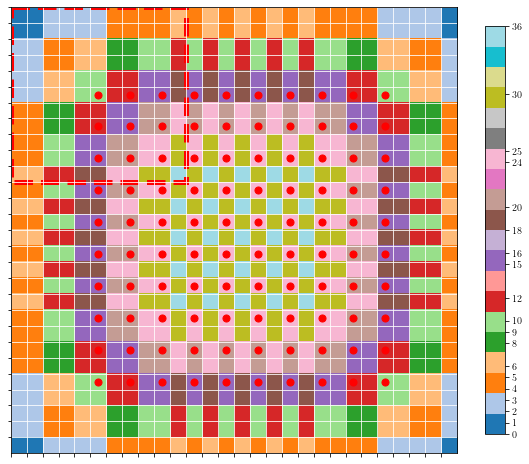

(784, 100)
Free model number of parameters: 78400
This model's number of parameters: 11881.0
Number of parameter Ratio: 0.15154336734693877


<Figure size 432x288 with 0 Axes>

In [3]:
from Mask import hidden_visible_mask


WINDOW = 5
t = 2

t_x = t
t_y = t
n_visible = 784
DIR = ""# Where to save the image, if none is given it is not saved ("Visible-Hidden Interactions")

mask = hidden_visible_mask(WINDOW,t_x,t_y,n_visible,show_hidden_loc = 1,MAIN = MAIN,
                           title = "",#"Visible-Hidden connections w = %s t = %s"%(WINDOW,t),
                           output_dir = "Images")
actual = mask.shape[0]*mask.shape[1]
reduced = np.sum(mask)
print(mask.shape)
print("Free model number of parameters: %s"%(actual))
print("This model's number of parameters: %s"%(reduced))
print("Number of parameter Ratio: %s"%(reduced/actual))

In [ ]:
6889.0/112896

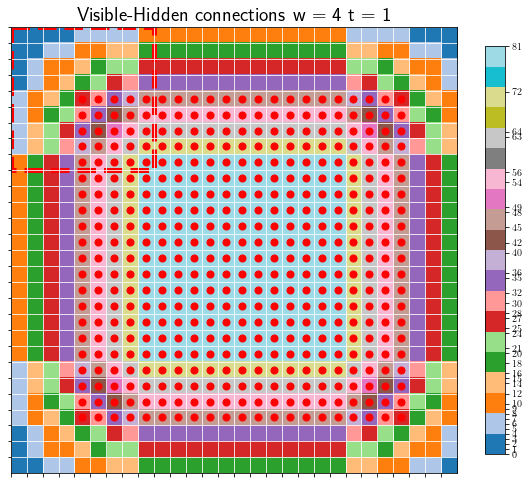

<Figure size 432x288 with 0 Axes>

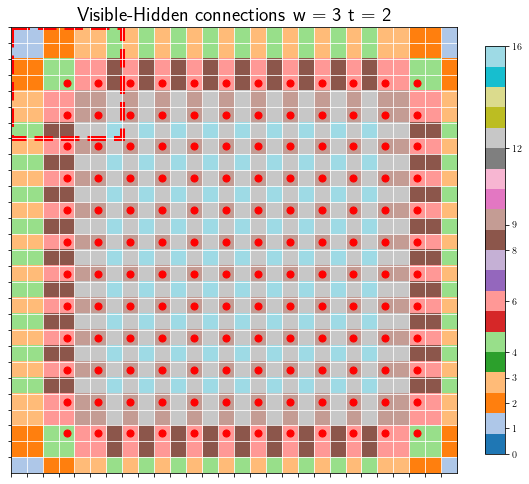

(784, 585)
Free model number of parameters: 458640
This model's number of parameters: 42233.0
Number of parameter Ratio: 0.09208311529740101


<Figure size 432x288 with 0 Axes>

In [34]:
WINDOW1 = 4
t1 = 1

t_x = t1
t_y = t1
n_visible = 784
DIR = ""# Where to save the image, if none is given it is not saved ("Visible-Hidden Interactions")

mask1 = hidden_visible_mask(WINDOW1,t_x,t_y,n_visible,show_hidden_loc = 1,
                           title = "Visible-Hidden connections w = %s t = %s"%(WINDOW1,t1),
                           output_dir = "")

WINDOW2 = 3
t2 = 2

t_x = t2
t_y = t2
n_visible = 784
DIR = ""# Where to save the image, if none is given it is not saved ("Visible-Hidden Interactions")

mask2 = hidden_visible_mask(WINDOW2,t_x,t_y,n_visible,show_hidden_loc = 1,
                           title = "Visible-Hidden connections w = %s t = %s"%(WINDOW2,t2),
                           output_dir = "")

mask = np.concatenate([mask1,mask2],axis = 1)
actual = mask.shape[0]*mask.shape[1]
reduced = np.sum(mask)
print(mask.shape)
print("Free model number of parameters: %s"%(actual))
print("This model's number of parameters: %s"%(reduced))
print("Number of parameter Ratio: %s"%(reduced/actual))

In [ ]:
plt.imshow(np.sum(mask,axis = 1).reshape((28,28)),cmap = "gray",aspect = "auto")

# LL evolution during training

In [ ]:
from Save_Load import load_rbm

In [ ]:
def LL_evolution(model_list,metrics,fig_name = "",**kwargs):
    fig,ax = plt.subplots(1,1,figsize = (20,10))
    for name in model_list:
        model = load_rbm(name,**kwargs)
        for metric in metrics:
            met = model.history[metric]
            ax.plot([i+1 for i in range(len(met))],met,label = metric+name)
    ax.legend()
    s = 30
    ax.tick_params(axis='both', length = 0)
    ax.set_xlabel("Epoch",fontsize = s)
    ax.set_ylabel("LL",fontsize = s)

    if fig_name:
        plt.savefig(os.path.join(MAIN,"Images",fig_name))
    else:
        plt.show()

In [ ]:
i = 9
mlist = ["RBM_n_hidden_81_MNIST_method_LL_seed_%s_epochs_500_lr_001_momentum_09_batch_size_64"%i,
        "RBM_n_hidden_81_MNIST_method_LL_window_2_stride_3_seed_%s_epochs_500_lr_001_momentum_09_batch_size_64"%i,
        "RBM_n_hidden_121_MNIST_method_LL_seed_%s_epochs_500_lr_001_momentum_09_batch_size_64"%i,
        "RBM_n_hidden_121_MNIST_method_LL_window_234_stride_444_seed_%s_epochs_500_lr_001_momentum_09_batch_size_64"%i,
        "RBM_n_hidden_162_MNIST_method_LL_seed_%s_epochs_500_lr_001_momentum_09_batch_size_64"%i,
        "RBM_n_hidden_162_MNIST_method_LL_window_12_stride_33_seed_%s_epochs_500_lr_001_momentum_09_batch_size_64"%i,
        "RBM_n_hidden_196_MNIST_method_LL_seed_%s_epochs_500_lr_001_momentum_09_batch_size_64"%i,
        "RBM_n_hidden_196_MNIST_method_LL_window_1_stride_2_seed_%s_epochs_500_lr_001_momentum_09_batch_size_64"%i]
LL_evolution(mlist,metrics = ["train_LL"],MAIN = MAIN)

# Image denoising

In [ ]:
CORRUPTIONS = [
    "identity",
    'shot_noise',
    'impulse_noise',
    'glass_blur',
    'motion_blur',
    'spatter',
    'dotted_line',
    'zigzag',
]

i = 0
mlist = ["RBM_n_hidden_81_MNIST_method_LL_seed_%s_epochs_500_lr_001_momentum_09_batch_size_64"%i,
        "RBM_n_hidden_81_MNIST_method_LL_window_2_stride_3_seed_%s_epochs_500_lr_001_momentum_09_batch_size_64"%i,
        "RBM_n_hidden_121_MNIST_method_LL_seed_%s_epochs_500_lr_001_momentum_09_batch_size_64"%i,
        "RBM_n_hidden_121_MNIST_method_LL_window_234_stride_444_seed_%s_epochs_500_lr_001_momentum_09_batch_size_64"%i,
        "RBM_n_hidden_162_MNIST_method_LL_seed_%s_epochs_500_lr_001_momentum_09_batch_size_64"%i,
        "RBM_n_hidden_162_MNIST_method_LL_window_12_stride_33_seed_%s_epochs_500_lr_001_momentum_09_batch_size_64"%i,
        "RBM_n_hidden_196_MNIST_method_LL_seed_%s_epochs_500_lr_001_momentum_09_batch_size_64"%i,
        "RBM_n_hidden_196_MNIST_method_LL_window_1_stride_2_seed_%s_epochs_500_lr_001_momentum_09_batch_size_64"%i]

In [ ]:
from Save_Load import from_dataset_to_array

In [ ]:
def image_denoising(model_list,corruptions,fig_name = "",**kwargs):
    fig,ax = plt.subplots(len(model_list)+1,len(corruptions),figsize = (20,10))
    img_dict = {}
    for j in range(len(corruptions)):
        DATA,DATA_LABEL = from_dataset_to_array(data_name = corruptions[j])
        img_dict[corruptions[j]] = DATA[j]
        ax[0,j].imshow(DATA[j].reshape((28,28)),cmap = "gray", aspect='auto')
        ax[0,j].axis("off")
    for i in range(len(model_list)):
        model = load_rbm(model_list[i],**kwargs)
        for j in range(len(corruptions)):
            ax[i+1,j].imshow(model.reconstruct(tf.expand_dims(img_dict[corruptions[j]], axis=0)).numpy().reshape((28,28)),cmap = "gray", aspect='auto')
            ax[i+1,j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0)
    if fig_name:
        plt.savefig(os.path.join(MAIN,"Images",fig_name))
    else:
        plt.show()

In [ ]:
image_denoising(mlist,CORRUPTIONS,MAIN = MAIN)